# VGG16_LargeFOV

## 1. Environment Setup


In [1]:
use_colab = False

In [2]:
use_gpu = False
if use_colab:
    ! git clone https://github.com/chendonghp/deeplab-v1.git
    ! pip install -U cython
    ! pip install git+https://github.com/lucasb-eyer/pydensecrf.git

    from google.colab import drive
    drive.mount('/content/drive')

    %cd deeplab-v1/Implementation/
    ! unzip /content/drive/MyDrive/data.zip -d ./dataset
    use_gpu = True

In [3]:
# Ignore Warning
import json
import os
import warnings

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import DataLoader

import train
from data import LungImageDataset, colorDict, compute_mean_std

warnings.filterwarnings(action="ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2024-01-23 06:01:38.094355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 06:01:38.108770: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 06:01:38.259739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 06:01:38.259873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 06:01:38.272743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

test
cpu


In [4]:
! ls

'DeepLab_v1 - SBD, VOC 2012.ipynb'   augmentation.py		   experiment
 Inference.ipynb		     best.pt			   model.py
 VGG16_LargeFOV_SBD_VOC_2012.ipynb   config.json		   train.py
 __init__.py			     config.json:Zone.Identifier   utils.py
 __pycache__			     data.py			   新建文件夹


In [5]:
import torch.optim.lr_scheduler as lr_scheduler

def create_scheduler(optimizer):
    return lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, verbose=True)

In [7]:
nesterov = True
create_scheduler = create_scheduler
if use_colab:
    data_root = r"./dataset"

    # dataset
    train_batch_size = 100
    test_batch_size = 60
    train_ratio = 0.9
    size = 12000  # select num of images to put in dataset
    train_size = int(size * train_ratio)
    train_range, val_range = (0, train_size), (train_size, size)

    # model parameters
    num_classes = len(colorDict.keys())
    ignore_index = 255

    # train hyperparameters
    epochs = 100
    lr = 0.001
    momentum = 0.9
    weight_decay = 0.0005
    init_weights = True

    # log and save
    path = "/content/drive/MyDrive/experiment/vgg16_largefov"
    load_path = path
    save_path = path
    log_path = path
    test_freq = 5
else:
    data_root = r"/mnt/d/data/"
    # dataset
    train_batch_size = 10
    test_batch_size = 20
    train_ratio = 0.9
    size = 120  # select num of images to put in dataset
    train_size = int(size * train_ratio)
    train_range, val_range = (0, train_size), (train_size, size)

    # model parameters
    num_classes = len(colorDict.keys())
    ignore_index = 255

    # train hyperparameters
    epochs = 20
    lr = 0.001
    momentum = 0.9
    weight_decay = 0.0005
    init_weights = True

    # log and save
    path = "experiment/vgg16_largefov"
    load_path = path
    save_path = path
    log_path = path
    test_freq = 5


if not os.path.exists(path):
    os.makedirs(path)

## 2. Data Preprocessing


In [8]:
def image_mean_std():
    dataset = LungImageDataset(
        data_root,
        transform=A.Compose([ToTensorV2()]),
        size=(0, size),
    )
    dataset_loader = DataLoader(
        dataset,
        batch_size=200,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    if not os.path.exists("config.json"):
        print("config.json file does not exist, compute now")
        mean, std = compute_mean_std(dataset_loader)
        mean, std = mean / 255, std / 255
        mean, std = mean.tolist(), std.tolist()
        data = {"mean": mean, "std": std}
        with open("config.json", "w") as f:
            json.dump(data, f)
        print("Mean:", mean)
        print("Std:", std)
    else:
        with open("config.json", "r") as f:
            data = json.load(f)
        mean, std = data["mean"], data["std"]
        print("Mean:", mean)
        print("Std:", std)
    return mean, std


mean, std = image_mean_std()

Mean: [0.7446640729904175, 0.5733005404472351, 0.7280433773994446]
Std: [0.21521449089050293, 0.2822308838367462, 0.18802255392074585]


In [9]:
train_tf = A.Compose(
    [
        A.Resize(256, 256),
        A.RandomCrop(256, 256),
        A.HorizontalFlip(),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(True),
    ]
)

val_tf = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=mean, std=std), ToTensorV2(True)]
)

In [10]:
train_dataset = LungImageDataset(data_root, size=train_range, transform=train_tf)
val_dataset = LungImageDataset(data_root, size=val_range, transform=val_tf)


train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# train_dataset = torchvision.datasets.SBDataset(root='./', image_set='train_noval', mode='segmentation', download=False, transforms=train_tf)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)

# val_dataset = torchvision.datasets.VOCSegmentation(root='./', year='2012', image_set='val', download=False, transforms=val_tf)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [11]:
train_features, train_labels = next(iter(train_loader))
train_features.shape, train_labels.shape

(torch.Size([10, 3, 256, 256]), torch.Size([10, 1, 256, 256]))

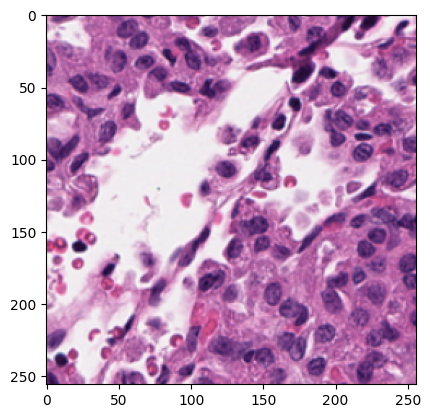

In [12]:
import matplotlib.pyplot as plt
import numpy as np

image_array = train_features[0].cpu().numpy()
if image_array.shape[0] == 3:
    image_array = image_array.transpose(1, 2, 0)
image_array = image_array * np.array(std) + np.array(mean)
# If the image is in CHW format, transpose it to HWC

plt.imshow(image_array)

## 3. Train Model


In [13]:
# %load_ext tensorboard
# %tensorboard --logdir  {path}/runs

In [14]:
vgg16_largefov = train.VGG16_LargeFOV(
    num_classes=num_classes,
    init_weights=init_weights,
    ignore_index=ignore_index,
    use_gpu=use_gpu,
    device=device,
)

In [15]:
await vgg16_largefov.train(
    train_loader,
    val_loader,
    load_path=None,
    save_path=save_path,
    log_path=log_path,
    epochs=epochs,
    test_freq=test_freq,
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay,
    nesterov=nesterov,
    create_scheduler=create_scheduler,
)

Train Started:  

Epoch : 0 Iter : 0 - Train Loss : 1.856690, Test Loss : 1.788763, Test mIoU : 2.2833, Test mpa : 2.4470
Training log saved to experiment/vgg16_largefov/vgg_largefov_training_log.csv.
Epoch : 0 Iter : 5 - Train Loss : 1.757228, Test Loss : 1.742920, Test mIoU : 6.9299, Test mpa : 9.0205
Training log saved to experiment/vgg16_largefov/vgg_largefov_training_log.csv.
Epoch : 0 Iter : 10 - Train Loss : 1.688187, Test Loss : 1.663646, Test mIoU : 8.9297, Test mpa : 14.4640
Training log saved to experiment/vgg16_largefov/vgg_largefov_training_log.csv.

 *********************************** Best mIoU Updated ***********************************
Epoch : 0 Iter : 10 - Train Loss : 1.688187, Test Loss : 1.663646, Test mIoU : 8.9297, Test mpa : 14.4640
Saved Model at experiment/vgg16_largefov/vgg16_large_fov_best.pt.

Saved Model at experiment/vgg16_largefov/vgg16_large_fov_latest.pt.
Epoch : 1 Iter : 0 - Train Loss : 1.650721, Test Loss : 1.635654, Test mIoU : 9.1788, Test mpa : 1